In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
# import MeshCat as mc 
# using JLD2
using Test
# using Random
# include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
# include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))

  Activating environment at `~/ocrl/Project/Project.toml`
[ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]


In [3]:
function rk4(params::NamedTuple, x::Vector, u::Vector, dt::Float64)
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + 0.5*k1, u)
    k3 = dt*dynamics(params, x + 0.5*k2, u)
    k4 = dt*dynamics(params, x + k3, u)
    
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

In [4]:
# function dynamics_tilde(params::NamedTuple, x::Vector, u::Vector)
#     g = params.g
#     L = params.L

#     r_tilde_ddot = 
# end

function dynamics(params::NamedTuple, X::Vector, u::Vector)
    g = params.g
    L = params.L

    x, y, z, x_dot, y_dot, z_dot, α, β, γ, r, s, r_dot, s_dot = X
    wx, wy, wz, a = u
    
    Rx = [1 0 0; 0 cos(γ) -sin(γ); 0 sin(γ) cos(γ)]
    Ry = [cos(β) 0 sin(β); 0 1 0; -sin(β) 0 cos(β)]
    Rz = [cos(α) -sin(α) 0; sin(α) cos(α) 0; 0 0 1]
    R = Rz*Ry*Rx

    pos_ddot = R * [0; 0; a] + [0; 0; -g]
    x_ddot, y_ddot, z_ddot = pos_ddot
    
    rot_dot = [cos(β)*cos(γ) -sin(γ) 0; cos(β)*sin(γ) cos(γ) 0; -sin(β) 0 1]\[wx; wy; wz]
    γ_dot, β_dot, α_dot = rot_dot

    ξ = sqrt(L^2 - r^2 - s^2)

    r_ddot = (L^4*x_ddot - r^3*s_dot^2 + r^4*x_ddot + r*s^3*y_ddot + r^3*s*y_ddot + L^2*r*r_dot^2 + L^2*r*s_dot^2 - 2*L^2*r^2*x_ddot - L^2*s^2*x_ddot + g*r^3*(L^2 - r^2 - s^2)^(1/2) - r*r_dot^2*s^2 + r^3*z_ddot*(L^2 - r^2 - s^2)^(1/2) + r^2*s^2*x_ddot - L^2*r*s*y_ddot + 2*r^2*r_dot*s*s_dot - L^2*g*r*(L^2 - r^2 - s^2)^(1/2) - L^2*r*z_ddot*(L^2 - r^2 - s^2)^(1/2) + g*r*s^2*(L^2 - r^2 - s^2)^(1/2) + r*s^2*z_ddot*(L^2 - r^2 - s^2)^(1/2))/(L^2*(- L^2 + r^2 + s^2))
    s_ddot = (L^4*y_ddot - r_dot^2*s^3 + s^4*y_ddot + r*s^3*x_ddot + r^3*s*x_ddot + L^2*r_dot^2*s + L^2*s*s_dot^2 - L^2*r^2*y_ddot - 2*L^2*s^2*y_ddot + g*s^3*(L^2 - r^2 - s^2)^(1/2) - r^2*s*s_dot^2 + s^3*z_ddot*(L^2 - r^2 - s^2)^(1/2) + r^2*s^2*y_ddot - L^2*r*s*x_ddot + 2*r*r_dot*s^2*s_dot - L^2*g*s*(L^2 - r^2 - s^2)^(1/2) - L^2*s*z_ddot*(L^2 - r^2 - s^2)^(1/2) + g*r^2*s*(L^2 - r^2 - s^2)^(1/2) + r^2*s*z_ddot*(L^2 - r^2 - s^2)^(1/2))/(- L^4 + L^2*r^2 + L^2*s^2)


    ### Normalized (x,y,z)
    # r_ddot = r/(L^2*ξ^2) * (g*ξ^3 - L^2*(r_dot^2 + s_dot^2) + (s*r_dot - r*s_dot)^2)
    # s_ddot = s/(L^2*ξ^2) * (g*ξ^3 - L^2*(r_dot^2 + s_dot^2) + (s*r_dot - r*s_dot)^2)

    return [x_dot; y_dot; z_dot; x_ddot; y_ddot; z_ddot; α_dot; β_dot; γ_dot; r_dot; s_dot; r_ddot; s_ddot]
end

dynamics (generic function with 1 method)

In [6]:
nx = 13
nu = 4

#           1  2  3  4  5  6      7      8      9 10 11     12     13
# States = [γ; β; α; x; y; z; x_dot; y_dot; z_dot; r; s; r_dot; s_dot]
# Inputs = [wx; wy; wz; a]

g = 9.81
L = 1.0

xgoal = [0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0]
ugoal = [0; 0; 0; g]

params = (g = 9.81, L = 1.0)

dt = 0.02

A = FD.jacobian(x -> rk4(params, x, ugoal, dt), xgoal)
B = FD.jacobian(u -> rk4(params, xgoal, u, dt), ugoal)

# x,y,z altogether
# Q = 1.0*diagm([0; 0; 0; 1; 1; 1; 0.5; 0.5; 0.5; 0; 0; 0; 0])
# R = 1.0*diagm([1; 1; 0; 1])

Q = 1.0*diagm([0; 0; 0; 1; 1; 0; 0.5; 0.5; 0; 0; 0; 0; 0])
R = 1.0*diagm([1; 1; 0; 1])

sing = 1e-6

P = deepcopy(Q)
K_old = (R + B'*P*B)\B'*P*A
P_old = Q + A'*P*(A-B*K_old)

Kinf = deepcopy(K_old)



for i = 1:1000
    # println("Iteration: ", i)
    K_new = (R + B'*P_old*B)\B'*P_old*A
    P_new = Q + A'*P_old*(A-B*K_new)
    if norm(K_new - K_old) < 1e-3
        Kinf = K_new
        println("Final Iteration: ", i)
        println("Kinf: ", Kinf)
        break
    end
    K_old = K_new
    P_old = P_new
end



Final Iteration: 52
Kinf: [0.0 0.0 0.0 0.0 -0.9242016581226934 0.0 0.0 0.0 4.258221326251292 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9271901823628584 0.0 0.0 0.0 4.314779718143687 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 50.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [21]:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
0.0 0.0 0.0 0.0 0.0 0.9641925416335908 0.0     0.0     1.5394031214205082  0.0  0.0  0.0     0.0
γ;  β;  α;  x;  y;  z;                 x_dot;  y_dot;  z_dot;              r;   s;   r_dot;  s_dot

4×4 Matrix{Float64}:
 1.001  0.0    0.0    0.0
 0.0    1.001  0.0    0.0
 0.0    0.0    0.001  0.0
 0.0    0.0    0.0    1.0012

In [27]:
C = [B A*B A^2*B A^3*B A^4*B A^5*B A^6*B A^7*B A^8*B A^9*B A^10*B A^11*B A^12*B]
rank(C)

5

Final Iteration: 602
Kinf: [0.0 0.8996345784529474 0.0 0.0 1.4312418538063452 0.0 0.0 0.0 10.043181504840907 0.0 21.21178640615491 0.0 6.766308423393449; -0.8996345784529451 0.0 0.0 -1.4312418538063407 0.0 0.0 0.0 10.04318150484091 0.0 -21.21178640615503 0.0 -6.766308423393437 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.9859573914130462 0.0 0.0 1.4042488295401294 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


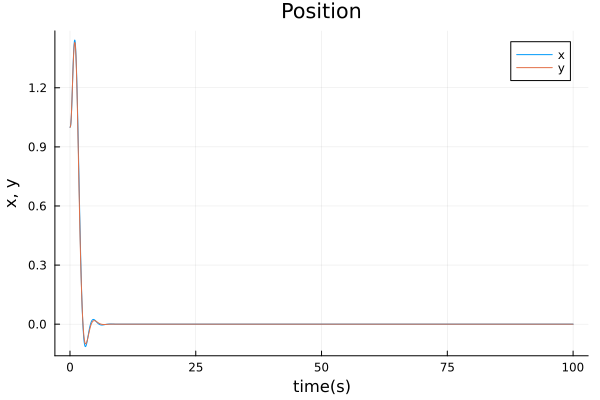

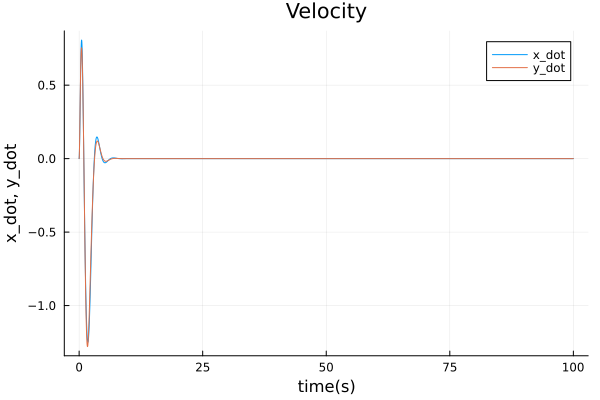

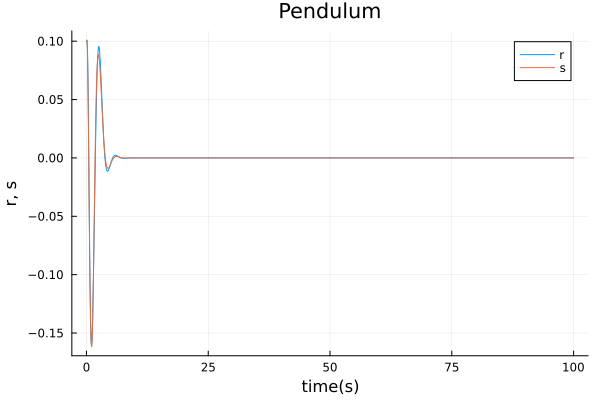

In [9]:
g = 9.81
L = 1.0
# Linearized continuous-time dynamics
Ac = [0 0 0 1 0 0 0 0  0   0   0 0 0;
      0 0 0 0 1 0 0 0  0   0   0 0 0;
      0 0 0 0 0 1 0 0  0   0   0 0 0;
      0 0 0 0 0 0 0 g  0   0   0 0 0;
      0 0 0 0 0 0 0 0 -g   0   0 0 0;
      0 0 0 0 0 0 0 0  0   0   0 0 0;
      0 0 0 0 0 0 0 0  0   0   0 0 0;
      0 0 0 0 0 0 0 0  0   0   0 0 0;
      0 0 0 0 0 0 0 0  0   0   0 0 0;
      0 0 0 0 0 0 0 0  0   0   0 1 0;
      0 0 0 0 0 0 0 0  0   0   0 0 1;
      0 0 0 0 0 0 0 -g 0 g/L   0 0 0;
      0 0 0 0 0 0 0 0  g   0 g/L 0 0]
      
Bc = [0 0 0 0;
      0 0 0 0;
      0 0 0 0;
      0 0 0 0;
      0 0 0 0;
      0 0 0 1;
      0 0 1 0;
      0 1 0 0;
      1 0 0 0;
      0 0 0 0;
      0 0 0 0;
      0 0 0 0;
      0 0 0 0]

# C = [Ac Bc Ac*Bc Ac^2*Bc Ac^3*Bc Ac^4*Bc Ac^5*Bc Ac^6*Bc Ac^7*Bc Ac^8*Bc Ac^9*Bc Ac^10*Bc Ac^11*Bc Ac^12*Bc]
# rank(C)
# good to go

nx = 13
nu = 4

##### discrete matrices #####
dt = 0.02         # NOTE: 50 Hz, may need to decrease for real-time implementation
exp_dis = exp([Ac Bc; zeros(nu,nx+nu)]*dt)
A_d = exp_dis[1:nx, 1:nx] # TODO 
B_d = exp_dis[1:nx, nx+1:end] # TODO 


##### RK4 matrices #####
# xgoal = [0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0]
# ugoal = [0; 0; 0; g]

# params = (g = 9.81, L = 1.0)

# dt = 0.02

# # RK4 doesn't match for some reason
# A_rk = FD.jacobian(x -> rk4(params, x, ugoal, dt), xgoal)
# B_rk = FD.jacobian(u -> rk4(params, xgoal, u, dt), ugoal)

# println(norm(A_rk - A_d))
# println(norm(B_rk - B_d))

##### 

x0 =    [1; 1; 0; 0; 0; 0; 0; 0; 0; 0.1; 0.1; 0; 0]
xgoal = [0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0]
ugoal = [0; 0; 0; g]

Q = 1.0*diagm([1; 1; 1; 0; 0; 0; 0; 0; 0; 1; 1; 0; 0])
R = 1.0*diagm([1; 1; 1; 1])

P = deepcopy(Q)

A = A_d     # For discrete-time matrices
B = B_d     # For discrete-time matrices

K_old = (R + B'*P*B)\B'*P*A
P_old = Q + A'*P*(A-B*K_old)

Kinf = deepcopy(K_old)

for i = 1:1000
    # println("Iteration: ", i)
    K_new = (R + B'*P_old*B)\B'*P_old*A
    P_new = Q + A'*P_old*(A-B*K_new)
    if norm(K_new - K_old) < 1e-9
        Kinf = K_new
        println("Final Iteration: ", i)
        println("Kinf: ", Kinf)
        break
    end
    K_old = K_new
    P_old = P_new
end

tf = 100.0
t_vec = 0:dt:tf
N = length(t_vec)
X = [zeros(nx) for i = 1:N]
X[1] = x0

for k = 1:N-1
      X[k+1] = rk4(params, X[k], ugoal - Kinf*(X[k] - xgoal), dt)

      # X[k+1] = A_d * X[k] + B_d *(ugoal - Kinf*(X[k] - xgoal))
      # X[k+1] = A_rk * X[k] + B_rk *(ugoal - Kinf*(X[k] - xgoal))
end

Xm = hcat(X...)
display(plot(t_vec,(Xm[1:2,:])',title = "Position",
            xlabel = "time(s)", ylabel = "x, y",
            label = ["x" "y"]))

display(plot(t_vec,(Xm[4:5,:])',title = "Velocity",
            xlabel = "time(s)", ylabel = "x_dot, y_dot",
            label = ["x_dot" "y_dot"]))

display(plot(t_vec,(Xm[10:11,:])',title = "Pendulum",
            xlabel = "time(s)", ylabel = "r, s",
            label = ["r" "s"]))

            

In [89]:
display("text/plain", A_d[:,8:end])
display("text/plain", A_rk[:,8:end])
A_dif = A_d - A_rk
display(A_dif[:,8:end])

13×6 Matrix{Float64}:
  0.001962     0.0         0.0       0.0       0.0        0.0
  0.0         -0.001962    0.0       0.0       0.0        0.0
  0.0          0.0         0.0       0.0       0.0        0.0
  0.1962       0.0         0.0       0.0       0.0        0.0
  0.0         -0.1962      0.0       0.0       0.0        0.0
  0.0          0.0         0.0       0.0       0.0        0.0
  0.0          0.0         0.0       0.0       0.0        0.0
  1.0          0.0         0.0       0.0       0.0        0.0
  0.0          1.0         0.0       0.0       0.0        0.0
 -0.00196264   0.0         1.00196   0.0       0.0200131  0.0
  0.0          0.00196264  0.0       1.00196   0.0        0.0200131
 -0.196328     0.0         0.196328  0.0       1.00196    0.0
  0.0          0.196328    0.0       0.196328  0.0        1.00196

13×6 Matrix{Float64}:
  0.001962     0.0         0.0       0.0       0.0        0.0
  0.0         -0.001962    0.0       0.0       0.0        0.0
  0.0          0.0         0.0       0.0       0.0        0.0
  0.1962       0.0         0.0       0.0       0.0        0.0
  0.0         -0.1962      0.0       0.0       0.0        0.0
  0.0          0.0         0.0       0.0       0.0        0.0
  0.0          0.0         0.0       0.0       0.0        0.0
  1.0          0.0         0.0       0.0       0.0        0.0
  0.0          1.0         0.0       0.0       0.0        0.0
 -0.00196264   0.0         1.00196   0.0       0.0200131  0.0
  0.0          0.00196264  0.0       1.00196   0.0        0.0200131
 -0.196328     0.0         0.196328  0.0       1.00196    0.0
  0.0          0.196328    0.0       0.196328  0.0        1.00196

13×6 Matrix{Float64}:
  0.0           0.0          0.0         0.0          0.0          0.0
  0.0           0.0          0.0         0.0          0.0          0.0
  0.0           0.0          0.0         0.0          0.0          0.0
  2.77556e-17   0.0          0.0         0.0          0.0          0.0
  0.0          -2.77556e-17  0.0         0.0          0.0          0.0
  0.0           0.0          0.0         0.0          0.0          0.0
  0.0           0.0          0.0         0.0          0.0          0.0
  0.0           0.0          0.0         0.0          0.0          0.0
  0.0           0.0          0.0         0.0          0.0          0.0
 -8.39238e-11   0.0          8.3924e-11  0.0          2.56654e-9   0.0
  0.0           8.39238e-11  0.0         8.39235e-11  0.0          2.56654e-9
 -2.51777e-8    0.0          2.51777e-8  0.0          8.39235e-11  0.0
  0.0           2.51777e-8   0.0         2.51777e-8   0.0          8.3924e-11